# Theory prediction for cosmoSLICS, with $n(z)$ implemented.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('modules')
import numpy as np
from numpy import sum, exp, pi, asarray

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy import units as u

from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline

import pandas as pd

import healpy as hp

from calculations_module import *
# from cosmology_module import Cosmology_function
# from variance_module import Variance
# from ratefunction_module import *
from criticalpoints_module import *
from computePDF_module import *
from variables_module import *

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import os

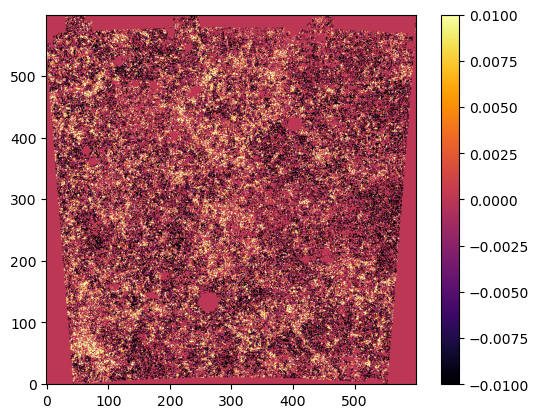

In [50]:
# load the data from the .npy file
data = np.load('/feynman/home/dap/lcs/at278006/data/cosmoSLICS/true_kappa_map_DES_MocksCat_fid_a_4_Bin4_LOS1_R15.npy')
plt.imshow(data, cmap='inferno', origin='lower', vmin=-0.01, vmax=0.01)
plt.colorbar()
plt.show()

The steps involved are as follows:

Step 1: Get the cosmological parameters

Step 2: Calculate the rate function and find the critical points

Step 3: Calculate the scaled CGF

step 4: Apply inverse lalpace transform on this to get the PDF

In the below code the critical points could be plotted if needed and the SCGf could also be plotted if needed by seeting the corresponding flags.

The l1 is obtained from the simulation PDF

Loading parameters..
now plotting the lensing weight


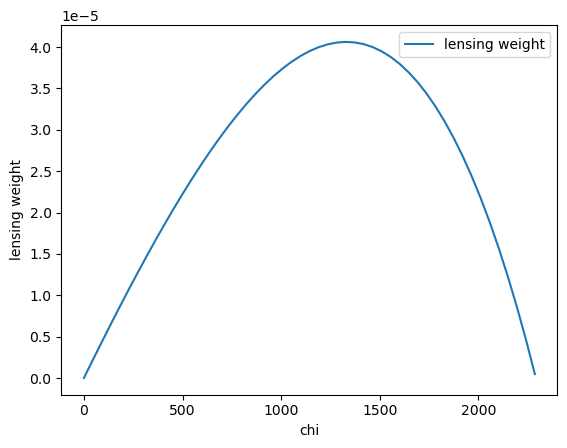

the source redshift is:  0.98
the chistar is:  2291.023085660988
the number of planes being used is:  51
The mass map variance from theory is:  7.744527389679062e-06


In [51]:
#######
# cosmoGRID simulation parameters
#######
h = 0.6898
Ob = 0.0473
Oc = 0.2432
mnu = 0.0
Om = Ob + Oc
ns = 0.969
As_ = 2.10
# As = As_ * 1e-9
Omnu = mnu / 93.14 / h / h
Ol = 1.0 - Om
Oc = Om - Ob - Omnu
H0 = 100.
speed_light = 299792.458

zs = 0.98 # approximate redshift of the 4th bin
theta1_input = 20.

nz_file_path = None

print("Loading parameters..")
# Initialize variables for simulation
variables = VariablesGenerator(h, H0, Ob, Oc, mnu, ns, As_, zs, theta1_input, nz_file_path)


Now computing for the cosmoSLICS simulation (top-hat smoothing)...


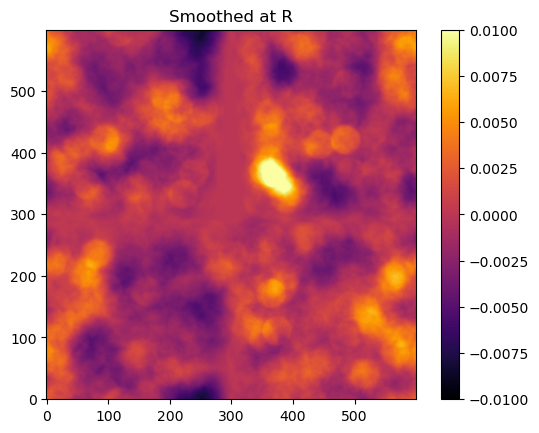

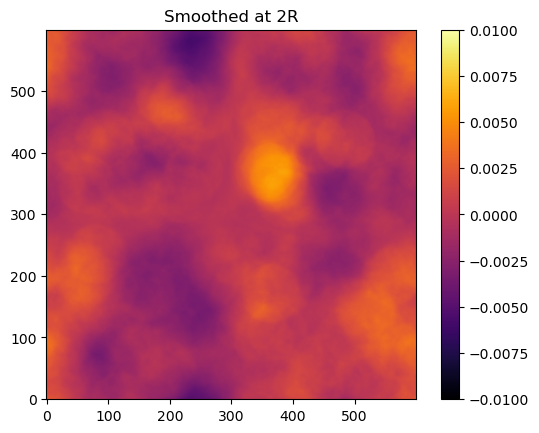

Assumed source redshift (mean n(z)): 0.98
The driving parameter is: 4.219163068421043


In [52]:
# Flag to load cosmoSLICS simulation data using top-hat smoothing
load_cosmoSLICS = True
if load_cosmoSLICS:
    print("\nNow computing for the cosmoSLICS simulation (top-hat smoothing)...")
    from cosmoslics_loader import CosmoSLICSLoader

    # Initialize the loader with the appropriate data path, physical map size, and map shape.
    loader = CosmoSLICSLoader(
        data_path="/feynman/home/dap/lcs/at278006/data/cosmoSLICS", 
        L=505, 
        map_shape=(600,600)
    )
    
    # 'theta1_input' now represents the window_radius (in arcmin).
    variance_cosmoSLICS, diff_map, (bin_edges, pdf_simulation) = loader.run_loader(
        window_radius=theta1_input, 
        binedges=100
    )
    
    # Here, diff_map is the difference between the map smoothed with 2*theta and with theta.
    # We interpret this as the "mass map difference" for further analysis.
    k_massmap_simulation = diff_map
    
    # Use the computed variance to update the recalibration parameter.
    variables.recal_value = variables.sigmasq_map / variance_cosmoSLICS
    print("The driving parameter is:", variables.recal_value)
    
    # Optionally, you can compute a representative kappa_sim from the histogram bin edges.
    kappa_sim = 0.5 * (bin_edges[:-1] + bin_edges[1:])

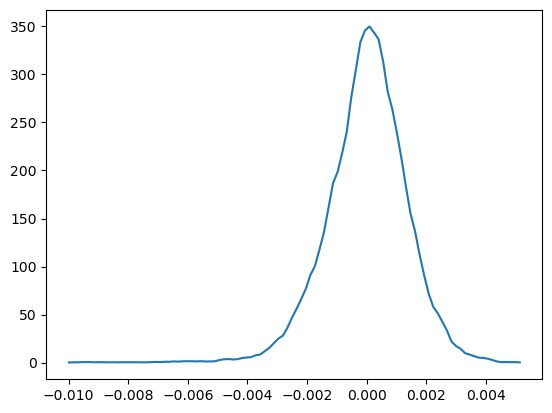

In [53]:
# plot the pdf
plt.plot(kappa_sim, pdf_simulation)

Calculating the critical points in each plane..
Setting ngrid = 100. Increase this for more accuracy, but note that computation becomes slower!
The approximate critical points at redshift z:  0.1  are:  [ 5154.30805956 -2799.60235823]
The approximate critical points at redshift z:  0.2  are:  [ 5978.43003008 -3089.4716104 ]
The approximate critical points at redshift z:  0.30000000000000004  are:  [-3491.11229334]


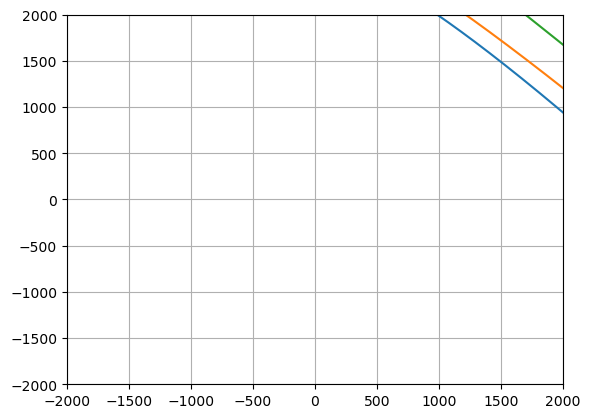

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [54]:
print("Calculating the critical points in each plane..")
criticalpoints = CriticalPointsFinder(variables, ngrid=100, plot=True)
critical_values = []
for i in range(1,4):
    critical_values.append(criticalpoints.get_critical_points(1*i*0.1))
plt.show()
critical_values = np.array(critical_values)
smallest_pair = find_smallest_pair(critical_values)
print("Smallest pair(s) of critical points are:", smallest_pair)
# plt.plot(critical_values[:,0],critical_values[:,1])

print(" ")

In [61]:
print("Getting the PDF..")
# variables.lambdas = np.linspace(smallest_pair[0][1]+30, smallest_pair[0][0]-100, 20)
variables.lambdas = np.linspace(-500, 600, 20)
computed_PDF = computePDF(variables, plot_scgf=False)
pdf_values, kappa_values = computed_PDF.pdf_values, computed_PDF.kappa_values

pdf_spline = CubicSpline(kappa_values, pdf_values)
pdf_theory = pdf_spline(kappa_sim)

# l1_pred = get_l1_from_pdf(pdf_theory, kappa_sim)
l1_pred = get_l1_from_pdf(pdf_values, kappa_values)
l1_sim = get_l1_from_pdf(pdf_simulation, kappa_sim)

Getting the PDF..
1.8355575231532202e-0627452 %%


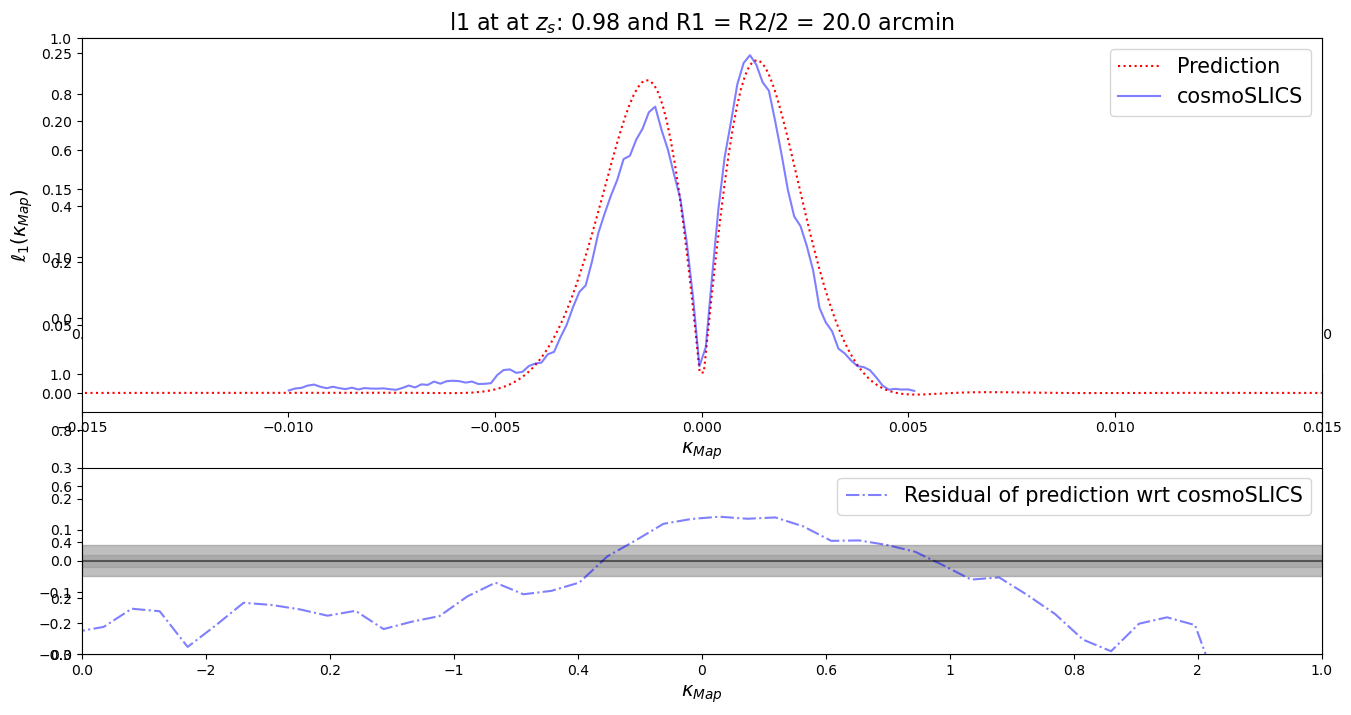

In [62]:
fig, axs = plt.subplots(2,1, figsize=(16,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

plt.subplot(gs[0, 0])
plt.plot(kappa_values, l1_pred, ls=":", c='r', label='Prediction')
plt.plot(kappa_sim, l1_sim, label="cosmoSLICS",c='b', alpha=0.5)
# plt.yscale('log')
plt.legend()
plt.xlabel(r'$\kappa_{Map}$', size = 14)
plt.ylabel(r'$\ell_1(\kappa_{Map})$', size = 14)
plt.legend(fontsize=15)
plt.xlim(-0.015,0.015)
# plt.title(r"l1 at at $z_s$: " + str(zs) + " and R1 = R2/2 = " + str(theta1_input) + " arcmin" , fontsize=16)
plt.title(r"l1 at at $z_s$: " + str(zs) + " and R1 = R2/2 = " + str(theta1_input) + " arcmin" , fontsize=16)

xlim_min = -0.0125
xlim_max = 0.008
l1_pred1 = get_l1_from_pdf(pdf_theory, kappa_sim)
plt.subplot(gs[1, 0])
plt.plot(kappa_sim/np.sqrt(variance_cosmoSLICS), (l1_sim-l1_pred1)/l1_sim, label="Residual of prediction wrt cosmoSLICS", ls="-.",c='b', alpha=0.5)
plt.legend(fontsize=15)
plt.xlabel(r'$\kappa_{Map}$', size = 14)
# plt.ylabel(r'$\frac{P(\mathrm{\kappa_{Map}}) - P_{prediction}(\mathrm{\kappa_{Map}})}{P_{prediction}(\mathrm{\kappa_{Map}})}$', size=14)
plt.ylim(-0.30,0.30)
plt.axhline(0,0,1,color='k',alpha=0.5)
plt.axhspan(-0.02,0.02,0,1,alpha=0.3,color='grey')
plt.axhspan(-0.05,0.05,0,1,alpha=0.5,color='grey')
plt.xlim(-2.5,2.5)
plt.show()


In [64]:
# Calculate statistical moments
pred_stat = get_moments(kappa_sim, pdf_theory)
sim_stat = get_moments(kappa_sim, pdf_simulation)
# Compare prediction and simulation
data = {
"Metric": ["Mean", "Variance", "Skewness", "Kurtosis","Norm"],
"Prediction PDF": pred_stat,
"Simulation PDF": sim_stat,
}
df = pd.DataFrame(data)
print(df)

zs_formatted = str(zs).replace('.', '_')

# Format the filename to include zs and theta1_input
filename = f"theory_values_{zs_formatted}_{theta1_input}"

# Format the content to save the calculated values
content = f"""
Computed Values:
- L1 Prediction: {l1_pred}
- PDF Prediction: {pdf_theory}
- kappa: {kappa_sim}
"""
theory_data = np.array([pdf_theory, l1_pred1, kappa_sim])

cwd = os.getcwd()
# Path to save the file
file_path = cwd+f"/paper/data/{filename}"
np.save(file_path, theory_data.T)

     Metric  Prediction PDF  Simulation PDF
0      Mean    2.373945e-08   -7.953943e-08
1  Variance    1.835231e-06    1.835494e-06
2  Skewness   -7.942103e+01   -4.866831e+02
3  Kurtosis    4.739642e-02    2.929187e+00
4      Norm    1.000032e+00    9.999639e-01
